**Setting up the environment**

In [ ]:
%%capture
files = !ls
files = [f.split("  ") for f in files][0]

isFRIQML = 'fri_qml' in files
isFRIQMLPath = isFRIQML and "setup.py" in files

# Clone the entire repo. Only run once!
if not isFRIQML:
  !git clone -l -s https://github.com/znajob/fri_qml.git fri_qml

if not isFRIQMLPath:
  %cd fri_qml

!git pull
!pip install -e .

In [ ]:
# MAIN IMPORTS
import numpy as np
import tensorflow as tf
import scipy
import matplotlib.pyplot as plt

## Matrix Product State Classification



### Exercise 1

Write a function `tensor_to_mps` that transforms that transforms a tensor into its MPS form with a given bond dimension. The arguments of the function are a tensor `A` to be decomposed and `D` the maximal bond dimension of the MPS decomposition. The function should return a list of MPS core tensors.

Write also a function `mps_to_tensor` that receives the MPS representation of a tensor (as a list of core tensors) and returns the contracted full tensor.

In [ ]:
import tensorflow as tf
from tensorflow_probability import math as tfp_math

In [ ]:
def tensor_to_mps(A, Dmax=8):
    N = int(np.log(np.prod(A.shape))/np.log(2))
    # Write the tensor as a matrid with only 2 rows
    B = np.reshape(A, [2, -1])
    mps = []
    for i in range(N-1):
        # Apply the SVD on the matrix B representing the remaining part of the tensor which has not been yet compressed
        # The option full_matrices=False means we only get non-zero singular values
        u, s, vh = np.linalg.svd(B, full_matrices=False)
        # We take only the first Dmax singular values if there are more
        D = min([Dmax, len(s)])
        # We reshape the tensor u into the shape [Dl,2,D], where Dl is determined automatically
        # and add it to the list of MPS tensors
        mps.append(np.reshape(u[:, :D], [-1, 2, D]))
        # We calculate the new B by concatenating s and vh and then reshaping.
        B = np.einsum("i,ij->ij", s[:D], vh[:D, :])
        B = np.reshape(B, [D*2, -1])
    # Finally we only reshape the last matrix B and append it to the MPS tensors
    mps.append(np.reshape(B, [D, 2, -1]))
    return mps


def mps_to_tensor(mps):
    tensor = np.array([[1]])
    N = len(mps)
    for i in range(N):
        tensor = np.einsum("...l,lir->...ir", tensor, mps[i])
    return tensor

In [ ]:
# TESTS
d = 512
A = np.dot(np.dot(np.random.rand(d,d),np.diag(list(np.random.rand(2))+list(np.zeros(d-2)))),np.random.rand(d,d))
N = int(np.log(np.prod(A.shape))/np.log(2))

mps = tensor_to_mps(A,Dmax=1024)
Ap = mps_to_tensor(mps)
diff_norm = np.linalg.norm(np.reshape(Ap,[-1])-np.reshape(A,[-1]))
print(np.linalg.norm(np.reshape(Ap,[-1])-np.reshape(A,[-1]))<1e-10)


mps = tensor_to_mps(A,Dmax=2**(int(N/4)+1))
Ap = mps_to_tensor(mps)
diff_norm = np.linalg.norm(np.reshape(Ap,[-1])-np.reshape(A,[-1]))/np.linalg.norm(A)
print(np.linalg.norm(np.reshape(Ap,[-1])-np.reshape(A,[-1]))<1e-10)

True
True


In [ ]:
# Compression rate
print(f"Rank of the matrix is {np.sum(np.linalg.eig(A)[0]>1e-12)}")
print(f"Tensor A has shape {A.shape} and can be written as a tensor with N={N} legs of size 2.")

print(f"The original tensor has {np.prod(A.shape)} parameters")
print(f"The compressed tensor has {np.sum([np.prod(M.shape) for M in mps])} parameters")

Rank of the matrix is 2
Tensor A has shape (512, 512) and can be written as a tensor with N=18 legs of size 2.
The original tensor has 262144 parameters
The compressed tensor has 19112 parameters


### Exercise 2

Write an embedding layer/class `Embedding` that transforms the input (possibly batched) tensor according to a generalised angle encoding

\begin{align}
  \left[\phi(x_j)\right]_\alpha= \sqrt{\begin{pmatrix}d-1\\ \alpha\end{pmatrix}} \cos^{d-\alpha}\left(\frac{\pi}{2}x_j\right) \sin^{\alpha}\left(\frac{\pi}{2}x_j\right).
\end{align}

The output of the layer should have the size $N\times N_{\rm batch}\times d$, where $N$ is the number of features of each input, $N_{\rm batch}$ is the batch size, and $d$ is the feature size. The constructor can take the feature size `d` as an argument.

In [ ]:
class Embedding(tf.keras.layers.Layer):
    def __init__(self, d=2):
        super(Embedding, self).__init__()
        self.d = d
        self.flatten = tf.keras.layers.Flatten()
        self.pi_half = tf.constant(np.pi / 2, dtype=tf.float32)

    def _binom(self, n, k):
        n = tf.cast(n, tf.float32)
        k = tf.cast(k, tf.float32)
        return tf.exp(tf.math.lgamma(n + 1) - tf.math.lgamma(k + 1) - tf.math.lgamma(n - k + 1))

    def call(self, inputs):
        x = self.flatten(inputs)  # (batch_size, N)
        x = tf.transpose(x)       # (N, batch_size)
        x = tf.cast(x, tf.float32)
        xc = tf.math.cos(x * self.pi_half)
        xs = tf.math.sin(x * self.pi_half)

        emb = []
        for j in range(self.d):
            coeff = tf.sqrt(self._binom(self.d - 1, j))
            term = coeff * tf.pow(xc, self.d - j - 1.0) * tf.pow(xs, j)
            emb.append(term)

        return tf.stack(emb, axis=-1)  # (N, batch_size, d)

In [ ]:
# TESTS
# Basis test
embedding = Embedding()
np.allclose(np.array(embedding(np.array([[1,0.5,0.]]))),np.array([[[-4.3711388e-08,  1.0000000e+00]],[[ 7.0710677e-01,  7.0710677e-01]],[[ 1.0000000e+00,  0.0000000e+00]]]))

True

### Exercise 3

Write a layer/class `MPS` that receives the output of the previously defined embedding and calculates the following contraction

\begin{align}
f^c(x)=\sum_{i_1,\ldots i_N=0}^1 A^{(1)}_{i_1}A^{(2)}_{i_2}\ldots A^{(N/2-1)}_{i_{N/2-1}} B^c_{i_{N/2}} A^{(N/2+1)}_{i_{N/2+1}}\ldots A^{(N)}_{i_N} \phi(x_1)_{i_1}\phi(x_2)_{i_2}\ldots \phi(x_N)_{i_N}
\end{align}
The tensors $A^{(j)}_{i_j}$ are matrices except for the first and the last one which are vectors. The index $c$ denotes the class and $B^c_{i_{N/2}}$ is a matrix. The output of the layer is a $N_{\rm batch}\times N_{\rm classes}$ tensor. The constructor parameters are
*  `D` -  bond dimension of the MPS,
*  `d` -  the feature size,
*  `C` -  number of classes.

The initial MPS tensors can be chosen randomly according to a Gaussian or a uniform distribution.


In [ ]:
class MPS(tf.keras.layers.Layer):
    def __init__(self, D, C, d=2, stddev=0.5):
        super(MPS, self).__init__()
        self.D = D
        self.d = d
        self.C = C
        self.stddev = stddev

    def build(self, input_shape):
        # input_shape: (N, batch_size, d)
        N = input_shape[0]
        d = input_shape[2]
        self.n = N

        self.tensor = self.add_weight(
            shape=(N, self.D, self.D, d),
            initializer=tf.keras.initializers.RandomNormal(stddev=self.stddev),
            trainable=True,
            name="core"
        )
        self.Aout = self.add_weight(
            shape=(self.C, self.D, self.D),
            initializer=tf.keras.initializers.RandomNormal(stddev=self.stddev),
            trainable=True,
            name="output"
        )

    def call(self, inputs):
        # inputs: (N, batch_size, d)
        A = tf.einsum("nbi,nlri->nblr", inputs,
                      self.tensor)  # (N, batch, D, D)

        nhalf = self.n // 2
        Al = A[0, :, 0, :]  # (batch, D)
        for i in range(1, nhalf):
            Al = tf.einsum("bl,blr->br", Al, A[i])

        Ar = A[-1, :, :, 0]  # (batch, D)
        for i in range(self.n - 2, nhalf - 1, -1):
            Ar = tf.einsum("blr,br->bl", A[i], Ar)

        Aout = tf.einsum("bl,olr->bor", Al, self.Aout)  # (batch, C, D)
        out = tf.einsum("bor,br->bo", Aout, Ar)         # (batch, C)
        return out

In [ ]:
# TEST
embedding = Embedding()
mps = MPS(D=3,C=8)
out = mps(embedding(np.random.rand(3,15)))
print((np.array(out.shape)==np.array([3,8])).all())

True


### Exercise 4
Combine the `Embedding`  and the `MPS` layers in a simple MPS classification model (name it `MPS_model`) and train it on the prepared toy dataset.

In [ ]:
class MPS_model(tf.keras.Model):
    def __init__(self, D, C=1, d=2, stddev=0.5):
        super(MPS_model, self).__init__()
        self.embedding = Embedding(d)
        self.mps = MPS(D=D, d=d, C=C, stddev=stddev)
        self.C = C

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.mps(x)
        if self.C > 1:
            return tf.keras.activations.softmax(x)
        else:
            return tf.keras.activations.sigmoid(x)

**Toy dataset with two classes**

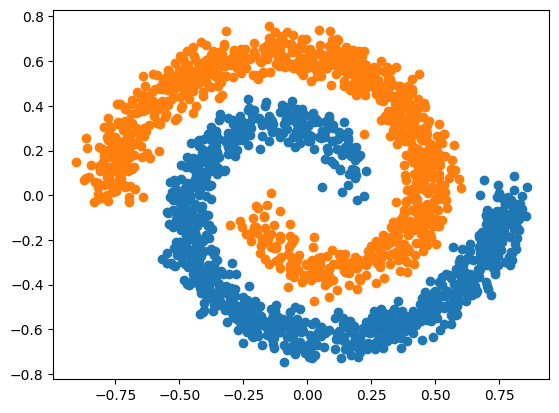

In [ ]:
from numpy import pi
# import matplotlib.pyplot as plt

N = 1000
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)


x_a = x_a/20.
x_b = x_b/20.

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

X_train = res[:N//2,:2]
Y_train = res[:N//2,2]

X_test = res[N//2:,:2]
Y_test = res[N//2:,2]


plt.scatter(x_a[:,0],x_a[:,1])
plt.scatter(x_b[:,0],x_b[:,1])
plt.show()

**Training**

In [ ]:
# By changing D, and d you can change the expressability of the model.

model = MPS_model(D=6,d=6,C=1,stddev=0.1)

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [ ]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.5, patience=10, verbose=2,
    mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)]

callbacks.append(tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=1e-3, patience=20, verbose=2,
    mode='auto', baseline=None, restore_best_weights=False
))

hist = model.fit(X_train,Y_train, batch_size=400, validation_split=0.1, epochs=1000, callbacks=callbacks, verbose=2)

Epoch 1/1000
2/2 - 2s - 859ms/step - accuracy: 0.4844 - loss: 0.6940 - val_accuracy: 0.4800 - val_loss: 0.6926 - learning_rate: 0.0100
Epoch 2/1000
2/2 - 0s - 75ms/step - accuracy: 0.6044 - loss: 0.6916 - val_accuracy: 0.7000 - val_loss: 0.6901 - learning_rate: 0.0100
Epoch 3/1000
2/2 - 0s - 48ms/step - accuracy: 0.7356 - loss: 0.6891 - val_accuracy: 0.8600 - val_loss: 0.6871 - learning_rate: 0.0100
Epoch 4/1000
2/2 - 0s - 51ms/step - accuracy: 0.8022 - loss: 0.6861 - val_accuracy: 0.8600 - val_loss: 0.6833 - learning_rate: 0.0100
Epoch 5/1000
2/2 - 0s - 48ms/step - accuracy: 0.8400 - loss: 0.6818 - val_accuracy: 0.8200 - val_loss: 0.6784 - learning_rate: 0.0100
Epoch 6/1000
2/2 - 0s - 49ms/step - accuracy: 0.8422 - loss: 0.6761 - val_accuracy: 0.7800 - val_loss: 0.6720 - learning_rate: 0.0100
Epoch 7/1000
2/2 - 0s - 48ms/step - accuracy: 0.8356 - loss: 0.6684 - val_accuracy: 0.7800 - val_loss: 0.6637 - learning_rate: 0.0100
Epoch 8/1000
2/2 - 0s - 46ms/step - accuracy: 0.8311 - loss: 

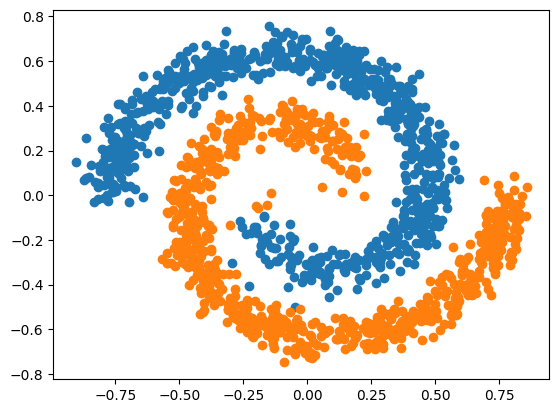

In [ ]:
preds = tf.reshape(model(X_test)>0.5,[-1]).numpy()
plt.scatter(X_test[preds==1,0],X_test[preds==1,1])
plt.scatter(X_test[preds==0,0],X_test[preds==0,1])
plt.show()

In [ ]:
model.summary()

Model: "mps_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mps_1 (MPS)                     │ ?                      │           468 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,406 (5.50 KB)

 Trainable params: 468 (1.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 938 (3.67 KB)